# Evaluation using QCB chemicals (medium)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists
import copy

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT

# 1. Parameters

In [5]:
DEBUG = False

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [6]:
from experiments import preset_qcb_medium
alpha = 0.50
beta = 0.50
extract = True
params, max_peaks = preset_qcb_medium(None, alpha=alpha, beta=beta, extract_chromatograms=extract)
params, max_peaks

2023-02-04 17:38:47.693 | INFO     | experiments:get_samplers:249 - Loaded /Users/joewandy/Work/git/vimms-gym/pickles/samplers_QCB_medium_extracted.p


({'chemical_creator': {'mz_range': (100, 600),
   'rt_range': (400, 800),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (200, 500),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fcf702a3520>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fcf94afa6d0>,
   'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fcf94b15970>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (100, 600)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (400, 800),
   'isolation_window': 0.7,
   'mz_tol': 10,
   'rt_tol': 120,
   'alpha': 0.5,
   'beta': 0.5}},
 200)

In [7]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (400, 800)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [8]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 200
in_dir = 'DQN'
out_dir = 'check_reward'
n_eval_episodes = 30

if DEBUG:
    n_eval_episodes = 2

## Generate chemical sets for evaluation

In [9]:
fname = 'QCB_chems_medium.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

265
352
460
402
456
494
450
228
442
354
299
264
335
295
416
334
275
244
392
290
441
411
433
386
245
261
436
494
246
256


In [10]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [11]:
set_log_level_warning()

1

In [12]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fcf702a3520>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fcf94afa6d0>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fcf94b15970>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 120,
  'alpha': 0.5,
  'beta': 0.5}}

In [13]:
horizon = 4
alphas = (0.00, 0.25, 0.50, 0.75, 1.00)
betas = (0.25, 0.50, 0.75)
method = 'DQN'

N = 0
min_ms1_intensity = 0

In [14]:
if DEBUG:
    alphas = (0.25, 0.75)
    betas = (0.50, )

In [15]:
data = []
for i in range(len(alphas)):
    alpha = alphas[i]
    for j in range(len(betas)):
        beta = betas[j]
        
        model_dir = os.path.join(in_dir)
        fname = os.path.join(model_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, METHOD_DQN, alpha, beta, horizon))
        print(fname)
        
        copy_params = copy.deepcopy(params)            
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta   
        
        custom_objects = {
            "learning_rate": 0.0,
            "lr_schedule": lambda _: 0.0,
            "clip_range": lambda _: 0.0,
        }            
        model = DQN.load(fname, custom_objects=custom_objects)        
        episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                      N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                      print_eval=False, print_reward=False, intensity_threshold=intensity_threshold,
                                      mzml_prefix=method, horizon=horizon)
        eval_results = [er.eval_res for er in episodic_results]
        
        for k in range(len(eval_results)):
            eval_res = eval_results[k]
            try:
                total_rewards = float(eval_res['total_rewards'])       
            except KeyError:
                total_rewards = 0.0

            try:
                invalid_action_count = float(eval_res['invalid_action_count'])       
            except KeyError:
                invalid_action_count = 0.0

            row = (
                alpha,
                beta,
                k,
                total_rewards, 
                invalid_action_count,
                float(eval_res['coverage_prop']), 
                float(eval_res['intensity_prop']), 
                float(eval_res['ms1ms2_ratio']), 
                float(eval_res['efficiency']),
                float(eval_res['precision']),
                float(eval_res['recall']),
                float(eval_res['f1']),            
            )
            data.append(row)

DQN/DDAEnv_DQN_alpha_0.00_beta_0.25_horizon_4.zip


/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:228: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 9.00GB > 0.69GB



DQN/DDAEnv_DQN_alpha_0.00_beta_0.50_horizon_4.zip


/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:228: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 9.00GB > 0.38GB



DQN/DDAEnv_DQN_alpha_0.00_beta_0.75_horizon_4.zip


/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:228: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 9.00GB > 0.36GB



DQN/DDAEnv_DQN_alpha_0.25_beta_0.25_horizon_4.zip
DQN/DDAEnv_DQN_alpha_0.25_beta_0.50_horizon_4.zip


/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:228: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 9.00GB > 0.35GB



DQN/DDAEnv_DQN_alpha_0.25_beta_0.75_horizon_4.zip


/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:228: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 9.00GB > 0.34GB



DQN/DDAEnv_DQN_alpha_0.50_beta_0.25_horizon_4.zip


/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:228: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 9.00GB > 0.33GB



DQN/DDAEnv_DQN_alpha_0.50_beta_0.50_horizon_4.zip
DQN/DDAEnv_DQN_alpha_0.50_beta_0.75_horizon_4.zip
DQN/DDAEnv_DQN_alpha_0.75_beta_0.25_horizon_4.zip
DQN/DDAEnv_DQN_alpha_0.75_beta_0.50_horizon_4.zip
DQN/DDAEnv_DQN_alpha_0.75_beta_0.75_horizon_4.zip
DQN/DDAEnv_DQN_alpha_1.00_beta_0.25_horizon_4.zip
DQN/DDAEnv_DQN_alpha_1.00_beta_0.50_horizon_4.zip
DQN/DDAEnv_DQN_alpha_1.00_beta_0.75_horizon_4.zip


In [16]:
df = pd.DataFrame(data, columns=['alpha', 'beta', 'iter', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
df.head()        

,alpha,beta,iter,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,0.0,0.25,0,439.554141,4.0,0.940,0.704,0.241,0.184,0.827,0.928,0.875
1,0.0,0.25,1,442.713049,28.0,0.926,0.685,0.207,0.231,0.828,0.912,0.868
2,0.0,0.25,2,338.457772,80.0,0.909,0.634,0.204,0.294,0.775,0.885,0.827
3,0.0,0.25,3,351.018145,73.0,0.918,0.663,0.196,0.257,0.813,0.901,0.855
4,0.0,0.25,4,348.008962,76.0,0.901,0.618,0.205,0.290,0.749,0.873,0.806


In [17]:
save_obj(df, 'check_reward_df.p')

### Load results

In [18]:
df = load_obj('check_reward_df.p')

In [19]:
df

,alpha,beta,iter,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,0.0,0.25,0,439.554141,4.0,0.940,0.704,0.241,0.184,0.827,0.928,0.875
1,0.0,0.25,1,442.713049,28.0,0.926,0.685,0.207,0.231,0.828,0.912,0.868
2,0.0,0.25,2,338.457772,80.0,0.909,0.634,0.204,0.294,0.775,0.885,0.827
3,0.0,0.25,3,351.018145,73.0,0.918,0.663,0.196,0.257,0.813,0.901,0.855
4,0.0,0.25,4,348.008962,76.0,0.901,0.618,0.205,0.290,0.749,0.873,0.806
...,...,...,...,...,...,...,...,...,...,...,...,...
445,1.0,0.75,25,228.800000,1.0,0.981,0.515,0.280,0.200,0.535,0.965,0.688
446,1.0,0.75,26,313.800000,7.0,0.956,0.526,0.280,0.325,0.578,0.927,0.712
447,1.0,0.75,27,351.400000,11.0,0.933,0.496,0.230,0.336,0.551,0.885,0.679
448,1.0,0.75,28,217.300000,3.0,0.955,0.541,0.286,0.185,0.596,0.927,0.725


<AxesSubplot:xlabel='alpha', ylabel='f1'>

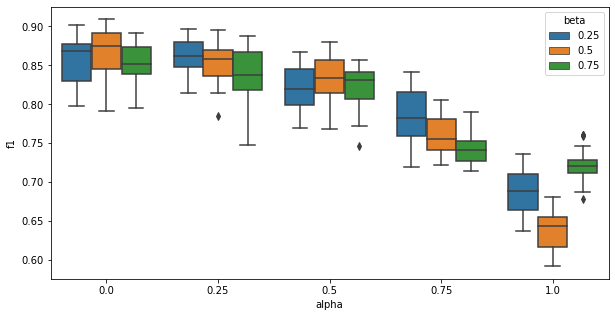

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='alpha', y='f1', hue='beta')

<AxesSubplot:xlabel='alpha', ylabel='coverage_prop'>

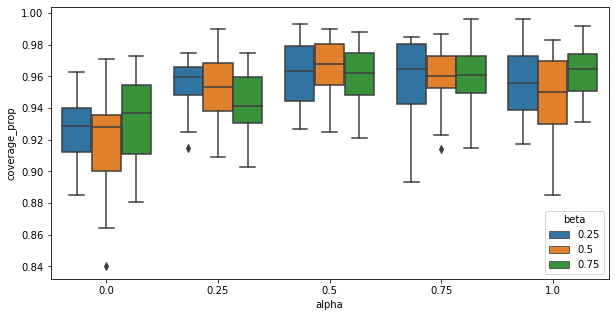

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='alpha', y='coverage_prop', hue='beta')

<AxesSubplot:xlabel='alpha', ylabel='intensity_prop'>

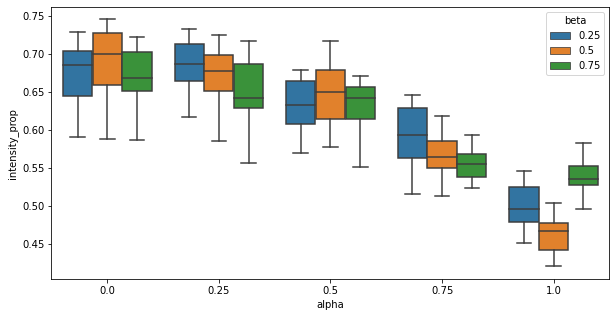

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='alpha', y='intensity_prop', hue='beta')